
# ARSENL Backscatter Experiments

Grant Kirchhoff
06-23-2022
University of Colorado Boulder

Fit the photon arrival rate to exponentiated polynomial profiles from ARSENL INPHAMIS lidar. 

IMPORTANT: Set data path settings in
'load_ARSENL_data.py' first.

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr

In [271]:
### CONSTANTS ####
c = 299792458                      # [m/s] Speed of light
tstamp_int = 25                    # Timestamp interval (e.g., timestamp recorded in intervals of 25)
max_rollover = 2**25 * tstamp_int  # [ps] the maximum timestamp before instrument timer rolls over

### PARAMETERS ###
exclude_bnd = [30000, 32000]           # Set boundaries for binning to exclude outliers
exclude = True                     # Set TRUE to exclude data to work with smaller dataset
excl_val = 10000                  # Include up to certain value

cwd = os.getcwd()
data_dir = cwd + r'/../Data/Deadtime_Experiments_HiFi'
fname = r'/Dev_0_-_2022-04-15_10.49.58.ARSENL.OD00.ARSENL.nc'

In [322]:
ds = xr.open_dataset(data_dir+fname)                                   # xarray Dataset

flight_time = ds.time_tag * tstamp_int
distance = flight_time / 1e12 * c / 2

flight_time = flight_time[np.where((flight_time >= exclude_bnd[0]) \
                                   & (flight_time < exclude_bnd[1]))]  # Exclude specified t.o.f. bins

cnt_phot = len(ds.sync_index)

if exclude:
    flight_time = flight_time[:excl_val]
    cnt_phot = ds.sync_index[ds.time_tag_sync_index[excl_val].item()].item()

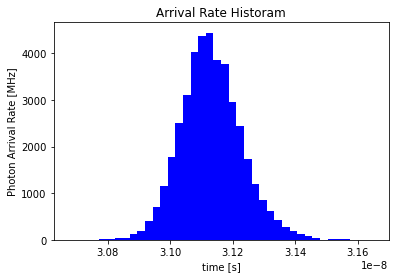

In [275]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
scale = 1e-12  # Scaling from psec --> sec
n, bins = np.histogram(flight_time*scale, bins=40)
binwidth = np.diff(bins)[0]
N = n / binwidth / cnt_phot_fit  # [Hz] Scale counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N/1e6, align='center', width=binwidth, color='b')
ax.set_title('Arrival Rate Histogram')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
plt.show()

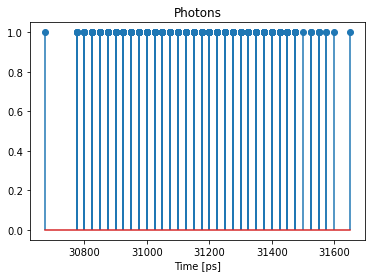

In [276]:
plt.figure()
plt.stem(flight_time, np.ones(flight_time.size))
plt.title('Photons')
plt.xlabel('Time [ps]')
plt.show()

### Now applying the curve_fit routine to my data. Code pulled from Matt Hayman's "Fit_TimeTag_Gaussian.ipynb" and adapted to fit to arbitrary exponentiated polynomials.

In [277]:
# Chebyshev polynomial matrix generator
def cheby_poly(x, M):
    """
    Parameters:
    x (array-like): Values to be evaluated on in chebyshev polynomial      \\ [Nx1]
    M (int)        : *Highest* order term of polynomial (e.g., x^2 --> M = 2) \\ []
    Returns:
    chebyshev polynomial matrix (array-like): Evaluated polynomial \\ [NxM]
    """
    
    def cheby(x, m):
        """
        Helper to calculate value of specific chebyshev order
        """
        T0 = x**0
        T1 = x**1
        if m == 0:   return T0
        elif m == 1: return T1
        else:        return 2*x*cheby(x, m-1) - cheby(x, m-2)
    
    N = len(x)
    model_out = np.zeros((N, M+1))
    for i in range(M+1):
        model_out[:, i] = cheby(x, i)
    
    return torch.tensor(model_out)

In [393]:
# build the fit model as a NN module
class Fit_Pulse(torch.nn.Module):
    def __init__(self, M, t_min, t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.M = M
        self.C = torch.nn.Parameter(-1*torch.ones(M+1, 1, dtype=float))
        self.t_max = t_max  # Fit upper bound
        self.t_min = t_min  # Fit lower bound
        
    # Helper for numerical integration (trapezoidal method)
    @staticmethod
    def trapezoid(vals, dx):
        trap_intgrl = 0
        for i in range(len(vals)-1):
            trap_intgrl += vals[i] + vals[i+1]
        trap_intgrl *= dx/2
        return trap_intgrl

    def forward(self, t, intgrl_N):
        """
        Forward model the profile for input time t of polynomial order M (e.g., x^2 --> M=2).
        Also return the integral.
        t (array-like): time stamps (unnormalized)               \\ [Nx1]
        intgrl_N (int): number of steps in numerical integration \\ []
        """
        M = self.M
        C = self.C
        
        # orthonormalize by leveraging chebyshev polynomials, then calculate forward model
        t_norm = 2*(t-self.t_min) / (self.t_max-self.t_min) - 1       # Normalize timestamps 
        t_poly_cheb = cheby_poly(t_norm, M)           # Generate chebyshev timestamp basis
        poly = t_poly_cheb @ C
        model_out = torch.exp(poly)             # Forward model
        
        # calculate the integral
        t_pts, dx = np.linspace(-1, 1, intgrl_N, retstep=True)  # Normalized time vector
        t_poly_cheb = cheby_poly(t_pts, M)                        # Generate chebyshev time basis
        poly = t_poly_cheb @ C
        eval_model = torch.exp(poly)
        integral_out = self.trapezoid(eval_model, dx)            # Numerically integrate (trapezoidal)
            
        return model_out, integral_out

In [394]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
#     print(integral)
#     print(torch.sum(torch.log(prof)))
    return integral-torch.sum(torch.log(prof))

In [395]:
# Generate fit and validation sets
# The target is assumed to be stationary so I can split the data in two
split_value = int(len(flight_time)//2)
t_phot_fit = flight_time[:split_value] * 1e-12  # Convert to seconds
t_phot_val = flight_time[split_value:] * 1e-12  # Convert to seconds
cnt_phot_fit = len(t_phot_fit)
cnt_phot_val = len(t_phot_val)

t_phot_fit_tnsr = torch.tensor(t_phot_fit.to_numpy())
t_phot_val_tnsr = torch.tensor(t_phot_val.to_numpy())

In [406]:
# optimization parameters

rel_step_lim = 1e-5  # termination criteria based on step size
max_epochs = 250     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations
intgrl_N = 100                   # Set number of steps in numerical integration

In [407]:
# I define the max/min times as fixed values. They are the upper/lower bounds of the fit.
# Time vector per shot (sync event)
t_min = exclude_bnd[0] * 1e-12
t_max = exclude_bnd[1] * 1e-12
dt = tstamp_int * 1e-12                                    # [s]
t_fine = np.arange(t_min, t_max, dt)

In [408]:
# # initialize for fit loop
# M = 4  # Polynomial order  (e.g., x^2 --> M=2)
# fit_model = Fit_Pulse(M, t_min, t_max)
# optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
# epoch = 0
# rel_step = 1e3*rel_step_lim
# fit_loss_lst = []
# val_loss_lst = []
# rel_step_lst = []

# init_C = np.zeros(M+1)
# for i in range(M+1):
#     init_C[i] = fit_model.C[i].item()

In [409]:
# # set the loss function to use a 
# # Poisson point process likelihood function
# loss_fn = pois_loss

In [410]:
# # perform fit
# start = time.time()
# while rel_step > rel_step_lim and epoch < max_epochs:
#     fit_model.train()
#     pred_fit, integral_fit = fit_model(t_phot_fit_tnsr, intgrl_N)
#     loss_fit = loss_fn(pred_fit, integral_fit*cnt_phot_fit)  # add regularization here
#     fit_loss_lst += [loss_fit.item()]
    
#     # Calculate validation loss
#     # Using fit from fit set, calculate loss when applied to validation set
#     pred_val, integral_val = fit_model(t_phot_val_tnsr, intgrl_N)
#     loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
#     val_loss_lst += [loss_val.item()]

#     # calculate relative step as an average over the last
#     # term_persist iterations
#     if epoch == 0:
#         rel_step_lst+=[1e3*rel_step_lim]
#         rel_step = 1e3*rel_step_lim
#     else:
#         rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
#         rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

#     # update estimated parameters
#     loss_fit.backward()
#     optimizer.step()
    
#     # zero out the gradient for the next step
#     optimizer.zero_grad()
    
#     epoch+=1

# end = time.time()
# print('Time elapsed: {:.2f} sec'.format(end-start))

In [411]:
M_max = 15
val_loss_arr = np.zeros(M_max+1)
print('Time elapsed:\n')
# Iterate through increasing polynomial complexity. Compare fit w/ validation set and minimize to find optimal polynomial order.
for i in range(M_max+1):
    # initialize for fit loop
    M = i  # Polynomial order  (e.g., x^2 --> M=2)
    fit_model = Fit_Pulse(M, t_min, t_max)
    optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
    epoch = 0
    rel_step = 1e3*rel_step_lim
    fit_loss_lst = []
    val_loss_lst = []
    rel_step_lst = []

    init_C = np.zeros(M+1)
    for i in range(M+1):
        init_C[i] = fit_model.C[i].item()

    # set the loss function to use a 
    # Poisson point process likelihood function
    loss_fn = pois_loss

    # perform fit
    start = time.time()
    while rel_step > rel_step_lim and epoch < max_epochs:
        fit_model.train()
        pred_fit, integral_fit = fit_model(t_phot_fit_tnsr, intgrl_N)
        loss_fit = loss_fn(pred_fit, integral_fit*cnt_phot_fit)  # add regularization here
        fit_loss_lst += [loss_fit.item()]

#         # Calculate validation loss
#         # Using fit from fit set, calculate loss when applied to validation set
#         pred_val, integral_val = fit_model(t_phot_val_tnsr, intgrl_N)
#         loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
#         val_loss_lst += [loss_val.item()]

        # calculate relative step as an average over the last
        # term_persist iterations
        if epoch == 0:
            rel_step_lst+=[1e3*rel_step_lim]
            rel_step = 1e3*rel_step_lim
        else:
            rel_step_lst+=[(fit_loss_lst[-2]-fit_loss_lst[-1])/np.abs(fit_loss_lst[-2])]
            rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

        # update estimated parameters
        loss_fit.backward()
        optimizer.step()

        # zero out the gradient for the next step
        optimizer.zero_grad()

        epoch+=1

    # Calculate validation loss
    # Using fit from fit set, calculate loss when applied to validation set
    pred_val, integral_val = fit_model(t_phot_val_tnsr, intgrl_N)
    loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
    val_loss_arr[i] = loss_val
        
    end = time.time()
    print('Order={}: {:.2f} sec'.format(i, end-start))

Time elapsed:

Order=0: 0.21 sec
Order=1: 0.23 sec
Order=2: 1.68 sec
Order=3: 2.00 sec
Order=4: 2.00 sec
Order=5: 2.11 sec
Order=6: 2.60 sec
Order=7: 2.82 sec
Order=8: 4.03 sec
Order=9: 5.49 sec
Order=10: 7.75 sec
Order=11: 10.85 sec
Order=12: 17.09 sec
Order=13: 35.94 sec
Order=14: 51.84 sec
Order=15: 77.75 sec


In [412]:
print(val_loss_arr)

[8470.73432357 8356.53678676 1204.26302381  921.42013541  577.94764501
  577.29969436  513.46926681  525.22615397  517.15808641  520.0841143
  517.74994475  515.42122786  514.59626566  519.78605232  521.20784493
  517.16014274]


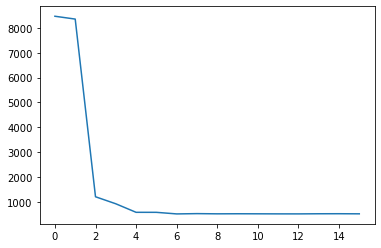

In [413]:
plt.plot(val_loss_arr)

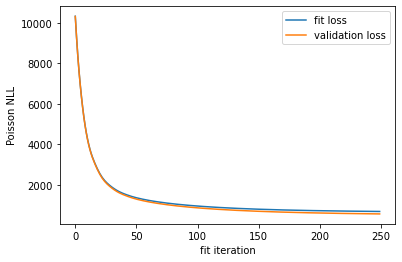

In [388]:
# # plot the loss over iterations
# plt.figure()
# plt.plot(fit_loss_lst,label='fit loss')
# plt.plot(val_loss_lst,label='validation loss')
# plt.xlabel('fit iteration')
# plt.ylabel('Poisson NLL')
# plt.legend()

In [389]:
for i in range(M+1):
    print('Initial C{}: {}'.format(i, init_C[i]))
print('\n')
for i in range(M+1):
    print('Final C{}: {:.4f}'.format(i, fit_model.C[i].item()))

Initial C0: -1.0
Initial C1: -1.0
Initial C2: -1.0
Initial C3: -1.0
Initial C4: -1.0


Final C0: -7.3291
Final C1: -0.1206
Final C2: -3.7329
Final C3: -3.7006
Final C4: 4.1845


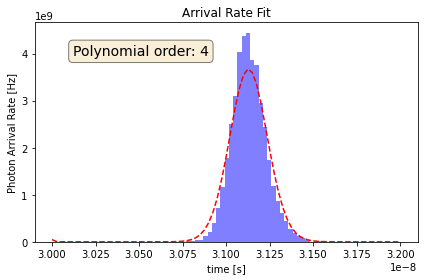

In [390]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Scaled histogram
scale = 1e-12
n, bins = np.histogram(flight_time*scale, bins=40)
binwidth = np.diff(bins)[0]
N = n / binwidth / cnt_phot  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='b', alpha=0.5)

# Arrival rate fit
t_seg_fine = np.arange(exclude_bnd[0]*1e-12, exclude_bnd[1]*1e-12, dt)
pred_mod_seg, __ = fit_model(torch.tensor(t_seg_fine), intgrl_N)
fit_rate_seg = pred_mod_seg.detach().numpy()  # [Hz] Fitted arrival rate
# TODO: CHECK SCALING. Not sure why scale 1e9.
fit_rate_seg *= 1e9  # Rescale for nanoseconds
ax.plot(t_seg_fine, fit_rate_seg,'r--')
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
# textstr = '\n'.join((
#     r'$C0=%.8f$' % (fit_model.C0),
#     r'$C1=%.8f$' % (fit_model.C1),
#     r'$C2=%.8f$' % (fit_model.C2)))
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# ax.text(0.55, 0.90, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.90, 'Polynomial order: {}'.format(M), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()


### Graveyard ###

In [93]:
class NumericalIntegrator:
    def riemann(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)):
            integral += f(eval_pts[i])
        integral *= dx
        return integral

    def trapezoidal(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-1):
            integral += f(eval_pts[i]) + f(eval_pts[i+1])
        integral *= dx / 2
        return integral

    def simpsons(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-2):
            integral += f(eval_pts[i]) + 4*f(eval_pts[i+1]) + f(eval_pts[i+2])
        integral *= dx / 2 / 3
        return integral
